In [2]:
import tabix
import pandas as pd
import os
import numpy as np
import sys
import tqdm.auto as tqdm

sys.path.append(
    os.path.abspath(
        os.path.join(
            "/data/pushkare/Chromatin_modules/4.quantify_3D_interactions", "src"
        )
    )
)
import utils
import peak_matrix_visualization as pmv
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
core_path = os.path.join(
    "/data/pushkare/Chromatin_modules/5.visualize_3D_interactions_and_peak_corr",
    "peak_correlations",
)
cm_path = "/data/pushkare/Chromatin_modules/1.mapped_CMs"
cm_peak_path = "/data/pushkare/Chromatin_modules/2.peaks_in_CMs/peak_files"

dataset = "test_data"

In [4]:
target_regions = pd.DataFrame(
    [
        [
            "chr22",
            23349145,
            23692745,
            "chr22_23349145_23692745_BCR",  # B cell receptor
            "crd76",
            "",
            "",
        ]
    ],
    columns=["chr_id", "start", "end", "pid", "cm_id", "rs_id", "LD_rs_ids"],
)

In [5]:
query = zip(
    target_regions["chr_id"],
    target_regions["start"],
    target_regions["end"],
    target_regions["pid"],
    target_regions["cm_id"],
    target_regions["rs_id"],
    target_regions["LD_rs_ids"],
)
corr_tabix = tabix.open(
    os.path.join(
        core_path,
        dataset + "_theoretical_corr_with_p_values_sorted.bed.gz",
    )
)
for chromosome, region_start, region_end, pid, _, _, _ in query:
    peak_corr = corr_tabix.query(chromosome, region_start, region_end)
    peaks_for_corr_mtx = []
    for peak_pair_info in peak_corr:
        if int(peak_pair_info[1]) <= int(peak_pair_info[5]):
            start_peak = int(peak_pair_info[1])
            end_peak = int(peak_pair_info[6])
        else:
            start_peak = int(peak_pair_info[5])
            end_peak = int(peak_pair_info[2])
        if (start_peak >= region_start) & (end_peak <= region_end):
            peaks_for_corr_mtx.append(
                [
                    peak_pair_info[0],
                    int(peak_pair_info[1]),
                    int(peak_pair_info[2]),
                    peak_pair_info[3],
                    peak_pair_info[4],
                    int(peak_pair_info[5]),
                    int(peak_pair_info[6]),
                    peak_pair_info[7],
                    float(peak_pair_info[-1]),
                ]
            )
    peaks_for_corr_mtx_df = pd.DataFrame(
        peaks_for_corr_mtx,
        columns=[
            "chr_1",
            "start_1",
            "end_1",
            "pid_1",
            "chr_2",
            "start_2",
            "end_2",
            "pid_2",
            "correlation",
        ],
    )
    pmv.get_corr_matrix(
        edgelist_df=peaks_for_corr_mtx_df,
        output_path=core_path,
        dataset=dataset,
        gene=pid,
        corr_file_name="correlation_matrix.txt",
    )

### Visualize CMs for all methods

In [7]:
square_corr = True

## Clomics parameters
n_peaks = "n_peaks_200"
bg_threshold = "bg_threshold_3"
## VCMtools parameters
vcm_window = "0.5Mb"
pv_threshold = "0.001"
## PHM parameter
pp_threshold = "0.8"

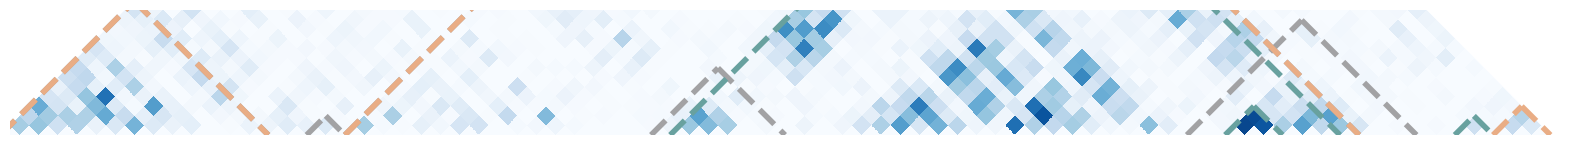

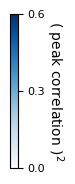

In [9]:
query = zip(
    target_regions["chr_id"],
    target_regions["start"],
    target_regions["end"],
    target_regions["pid"],
    target_regions["cm_id"],
    target_regions["rs_id"],
    target_regions["LD_rs_ids"],
)
corr_tabix = tabix.open(
    os.path.join(
        core_path,
        dataset + "_theoretical_corr_with_p_values_sorted.bed.gz",
    )
)
fig_output_path = os.path.join(core_path, "plots", dataset)
if not os.path.exists(fig_output_path):
    os.makedirs(fig_output_path)
for chromosome, region_start, region_end, pid, _, _, _ in query:
    gene_name = pid.split("_")[-1]
    crds_in_region = utils.get_cms_in_region(
        cm_path,
        "clomics",
        dataset,
        chromosome,
        region_start,
        region_end,
        fully_in=True,
        n_peaks=n_peaks,
        bg_threshold=bg_threshold,
    )
    vcms_in_region = utils.get_cms_in_region(
        cm_path,
        "vcmtools",
        dataset,
        chromosome,
        region_start,
        region_end,
        fully_in=True,
        vcm_window=vcm_window,
        pv_threshold=pv_threshold,
    )
    phms_in_region = utils.get_cms_in_region(
        cm_path,
        "phm",
        dataset,
        chromosome,
        region_start,
        region_end,
        fully_in=True,
        pp_threshold=pp_threshold,
    )
    crd_peak_dict = utils.get_cm_peak_dict(
        cm_peak_path, method="clomics", dataset=dataset
    )
    vcm_peak_dict = utils.get_cm_peak_dict(
        cm_peak_path, method="vcmtools", dataset=dataset
    )
    phm_peak_dict = utils.get_cm_peak_dict(cm_peak_path, method="phm", dataset=dataset)
    corr_df_for_viz = pmv.prepare_data_for_corr_heatmap(
        input_path=core_path,
        dataset=dataset,
        gene=pid,
        corr_file_name="correlation_matrix.txt",
        square_corr=square_corr,
    )
    crd_coordinates = pmv.get_cm_coordinates(
        corr_or_hic_peak_df=corr_df_for_viz,
        cm_dict=crd_peak_dict,
        cms_to_plot=crds_in_region,
        data_type="corr",
    )
    vcm_coordinates = pmv.get_cm_coordinates(
        corr_or_hic_peak_df=corr_df_for_viz,
        cm_dict=vcm_peak_dict,
        cms_to_plot=vcms_in_region,
        data_type="corr",
    )
    phm_coordinates = pmv.get_cm_coordinates(
        corr_or_hic_peak_df=corr_df_for_viz,
        cm_dict=phm_peak_dict,
        cms_to_plot=phms_in_region,
        data_type="corr",
    )
    if square_corr:
        vmin_norm_ = 0
        vmax_norm_ = corr_df_for_viz.max().max() + 0.1 * corr_df_for_viz.max().max()
        cbar_label = "( peak correlation )$^2$"
        title_str = "squared"
    else:
        vmin_ = corr_df_for_viz.min().min()
        vmax_ = corr_df_for_viz.max().max()
        abs_max_ = max(abs(vmin_), abs(vmax_))
        vmin_norm_ = -abs_max_
        vmax_norm_ = abs_max_
        cbar_label = "peak correlation"
        title_str = "raw"
    pmv.plot_peak_corr_heatmap(
        dataset,
        corr_data=corr_df_for_viz,
        line_width=4,
        ylim_fraction=0.6,
        vmin_norm=vmin_norm_,
        vmax_norm=vmax_norm_,
        save_fig=True,
        square_corr=square_corr,
        crd_coordinates=crd_coordinates,
        vcm_coordinates=vcm_coordinates,
        phm_coordinates=phm_coordinates,
        cbar_label=cbar_label,
        suffix="_".join(
            [
                pid,
                title_str,
                "correlation_matrix",
                "vcmtools",
                "clomics",
                "phm",
                "CMs",
            ]
        ),
        output_path=fig_output_path,
    )